### Objective: 
Model work time per note with a linear regression


### Input Variables:

#### Scribe Experience:
- Note count (number of notes a scribe has written on the day of completion of the note)
- Length of experience (number of days as a scribe, measured from the day of first note to completion day of note)

#### Note Data:
- E&M Level (Level 1-5)
- Patient Stage (New, Established, Telehealth, Post-Op, Pre-Op)


### Summary:

With the assumption that inexperienced scribes and notes that require more input will take longer to write, scribe experience and note data (E&M level and patient stage) were included as predictors. 

To account for the multicollinearity between total notes written and number of days of scribe experience, the two variables were added together to create a more general "experience" input, then square-root transformed due to the right skewed distribution of both of the variables. Ordinal encoding was applied to the E&M level and patient stage variables.

The linear model returned a R-squared value of about 0.70, albeit with a condition number of 48.

In [98]:
import numpy as np
import pandas as pd
from pandas import DataFrame

import matplotlib.pyplot as plt
import sklearn 
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [99]:
#import appointments table 
appts = pd.read_csv (r'/Users/jihyun.byun/Downloads/bq-results-20210817-141033-zdui0h9d1jli.csv')
df = pd.DataFrame(appts)

#print(appts.head())

In [100]:
#removing rows with "Robin" and "Test" specialties
df = df[(df.group_name != 'Robin') & (df.group_name != 'Test') & (df.group_name != 'the pepper group')]

In [101]:
#create integer for E&M Level, ordinal encoding
def fx(row):
    if row['em_level'] == 'Level 1': val = 1
    elif row['em_level'] == 'Level 2': val = 2
    elif row['em_level'] == 'Level 3': val = 3
    elif row['em_level'] == 'Level 4': val = 4
    elif row['em_level'] == 'Level 5': val = 5
    else : val = 0

    return val

#create new column using the function above
df['em_level_int'] = df.apply(fx, axis=1)

In [102]:
#create integer for Patient Stage, ordinal encoding
def fx(row):
    if row['pt_stage'] == 'Pre-Op': val = 1
    elif row['pt_stage'] == 'Post-Op': val = 2
    elif row['pt_stage'] == 'Telehealth': val = 3
    elif row['pt_stage'] == 'Established': val = 4
    elif row['pt_stage'] == 'New': val = 5
    else : val = 0

    return val

#create new column using the function above
df['pt_stage_int'] = df.apply(fx, axis=1)

In [103]:
#drop unneeded columns
df_ltd = df.drop(['appointment_id', 'doctor_id', 'patient_stage', 'initial_completion_date', 
                  'extractor_id', 'extractor_name', 'first_note_date', 'doctor_name', 
                  'em_code', 'group_id', 'specialty_id',
                  'sub_specialty_name', 'sub_specialty_id', 
                  'procedures_string'], axis=1)

#df_ltd.head()

In [104]:
#reorder columns
#cols = list(df_ltd.columns.values)
#cols

df_ltd = df_ltd[['days_scribing', 'daily_note_count', 
                 'group_name', 'specialty_name',
                 'pt_stage_int', 'pt_stage', 'em_level_int', 'em_level',
                 'worktime']]
#df_ltd

In [105]:
#check for null specialty values
null_specialty = df[df['specialty_name'].isna()]
#null_specialty

In [106]:
#check for null days of scribe experience values
null_days = df_ltd[df_ltd['days_scribing'].isna()]
#null_days

In [107]:
#check for null note ct values
null_note_ct = df[df['daily_note_count'].isna()]
#null_note_ct

In [108]:
#check for null worktime values
null_worktime = df[df['worktime'].isna()]
#null_worktime

In [109]:
#check for notes with zero worktime 
zero_worktime = df[df['worktime'] == 0]
#zero_worktime

In [110]:
#check for notes with worktime > 5 hours
worktime_5hr = df[df['worktime'] >= 300]
#worktime_5hr

In [111]:
#remove rows with null values for days of experience, scribe note count, 
# or worktime equal to 0 or greater than 4 hours

df_clean = df_ltd[(df_ltd['daily_note_count'].notna() & 
                   df_ltd['days_scribing'].notna() & 
                   df_ltd['worktime'].notna() &
                   (df_ltd['days_scribing'] >= 0) &
                   (df_ltd['worktime'] != 0) &
                   (df_ltd['worktime'] < 240))]

In [112]:
df_clean['experience'] = df_ltd['daily_note_count'] + df_ltd['days_scribing']
#df_clean.info()

In [113]:
#replace null (NaN) values with "N/A"
df_clean = df_clean.replace(np.nan, 'N/A', regex=True)
#df_clean.head()

In [114]:
#declare days scribing, daily note count, and worktime as integers
df_clean['days_scribing'] = df_clean['days_scribing'].astype('int64')
df_clean['daily_note_count'] = df_clean['daily_note_count'].astype('int64')
df_clean['worktime'] = df_clean['worktime'].astype('int64')
df_clean['experience'] = df_clean['experience'].astype('int64')

Text(0.5, 1.0, 'Histogram of Work Time per Note')

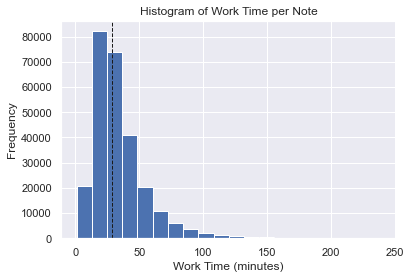

In [115]:
plt.hist(df_clean['worktime'], bins = 20)
plt.axvline(df_clean['worktime'].median(), color='k', linestyle='dashed', linewidth=1)

#plt.hist(df_clean['worktime'], bins = [0,20,40,60,80,100,300])
#plt.hist(df_clean['worktime'], bins = [0,2,4,6,8,10])

sns.set(rc={'figure.figsize':(6,4)})


plt.xlabel("Work Time (minutes)")
plt.ylabel("Frequency")
plt.title("Histogram of Work Time per Note")



### Checking linear regression assumptions: normal distribution of input variables and linear relationship between input / output vars

#### Days of Scribing Experience

1.9027259739133102


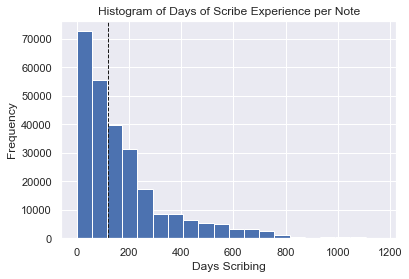

In [116]:
plt.hist(df_clean['days_scribing'], bins = 20)
plt.axvline(df_clean['days_scribing'].median(), color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Days Scribing")
plt.ylabel("Frequency")
plt.title("Histogram of Days of Scribe Experience per Note")

print(df_clean['days_scribing'].skew())

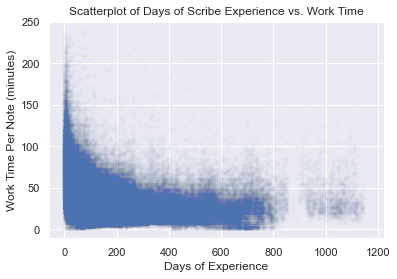

In [117]:
#create scatterplot
plt.xlabel("Days of Experience")
plt.ylabel("Work Time Per Note (minutes)")
plt.title("Scatterplot of Days of Scribe Experience vs. Work Time")
plt.scatter(df_clean['days_scribing'], df_clean['worktime'], s = 10, alpha = 0.01);
plt.show()

0.7351372003968387


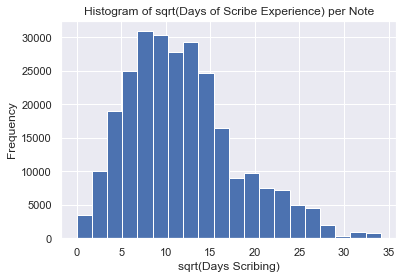

In [138]:
df_clean['days_scribing_sqrt'] = np.sqrt(df_clean['days_scribing'])

plt.hist(np.sqrt(df_clean['days_scribing']), bins = 20)
plt.xlabel("sqrt(Days Scribing)")
plt.ylabel("Frequency")
plt.title("Histogram of sqrt(Days of Scribe Experience) per Note")
print(np.sqrt(df_clean['days_scribing']).skew())

Applying square root transformation reduces skew from ~1.9 (highly skewed) to ~0.7 (moderate to low skew); scatterplot between below more closely resembles linear relationship

Text(0.5, 1.0, 'Scatterplot of sqrt(Days of Scribe Experience) vs. Work Time')

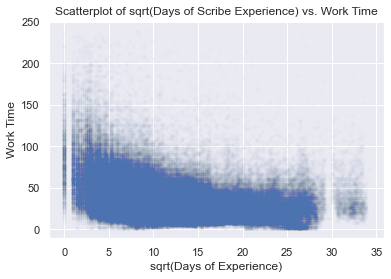

In [136]:
plt.scatter(np.sqrt(df_clean['days_scribing']), df_clean['worktime'], s = 10, alpha = 0.01);
plt.xlabel("sqrt(Days of Experience)")
plt.ylabel("Work Time")
plt.title("Scatterplot of sqrt(Days of Scribe Experience) vs. Work Time")

#### Daily Note Count

1.5049383446698053


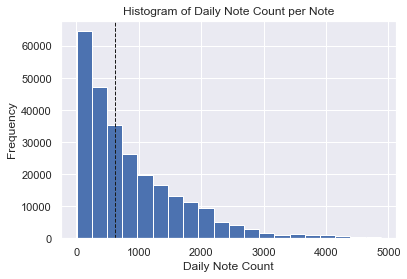

In [120]:
plt.hist(df_clean['daily_note_count'], bins = 20)
plt.axvline(df_clean['daily_note_count'].median(), color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Daily Note Count")
plt.ylabel("Frequency")
plt.title("Histogram of Daily Note Count per Note")

print(df_clean['daily_note_count'].skew())

Text(0.5, 1.0, 'Scatterplot of sqrt(Daily Note Count) vs. Work Time')

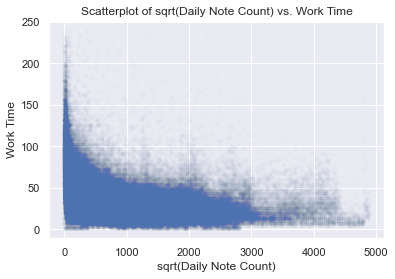

In [121]:
plt.scatter((df_clean['daily_note_count']), df_clean['worktime'], s = 10, alpha = 0.01);
plt.xlabel("sqrt(Daily Note Count)")
plt.ylabel("Work Time")
plt.title("Scatterplot of sqrt(Daily Note Count) vs. Work Time")

0.4579605573691427


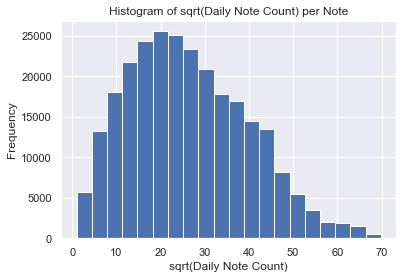

In [139]:
df_clean['daily_note_count_sqrt'] = np.sqrt(df_clean['daily_note_count'])

plt.hist(df_clean['daily_note_count_sqrt'], bins = 20)
plt.xlabel("sqrt(Daily Note Count)")
plt.ylabel("Frequency")
plt.title("Histogram of sqrt(Daily Note Count) per Note")
print(np.sqrt(df_clean['daily_note_count']).skew())

Text(0.5, 1.0, 'Scatterplot of sqrt(Daily Note Count) vs. Work Time')

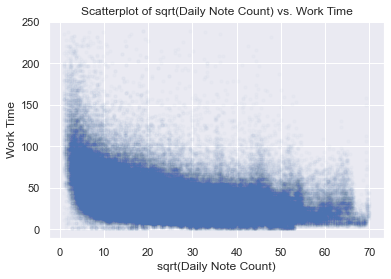

In [140]:
plt.scatter(np.sqrt(df_clean['daily_note_count']), df_clean['worktime'], s = 10, alpha = 0.02);
plt.xlabel("sqrt(Daily Note Count)")
plt.ylabel("Work Time")
plt.title("Scatterplot of sqrt(Daily Note Count) vs. Work Time")

Text(0.5, 1.0, 'Histogram of experience per Note')

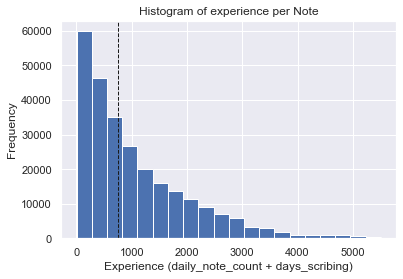

In [124]:
plt.hist(df_clean['experience'], bins = 20)
plt.axvline(df_clean['experience'].median(), color='k', linestyle='dashed', linewidth=1)

plt.xlabel("Experience (daily_note_count + days_scribing)")
plt.ylabel("Frequency")
plt.title("Histogram of Experience per Note")

0.4439142581630662


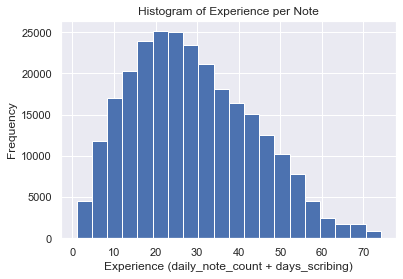

In [125]:
plt.hist(np.sqrt(df_clean['experience']), bins = 20)

plt.xlabel("Experience (daily_note_count + days_scribing)")
plt.ylabel("Frequency")
plt.title("Histogram of Experience per Note")
print(np.sqrt(df_clean['experience']).skew())

Text(0.5, 1.0, 'Scatterplot of sqrt(Experience) vs. Work Time')

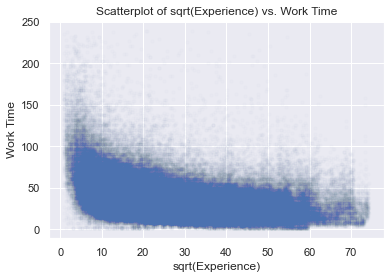

In [126]:
df_clean['experience_sqrt'] = np.sqrt(df_clean['experience'])

plt.scatter(df_clean['experience_sqrt'], df_clean['worktime'], s = 10, alpha = 0.01);
plt.xlabel("sqrt(Experience)")
plt.ylabel("Work Time")
plt.title("Scatterplot of sqrt(Experience) vs. Work Time")

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Median Worktime'),
 Text(0.5, 1.0, 'Median Worktime/Note per Specialty with 1 St.Dev Error Bars')]

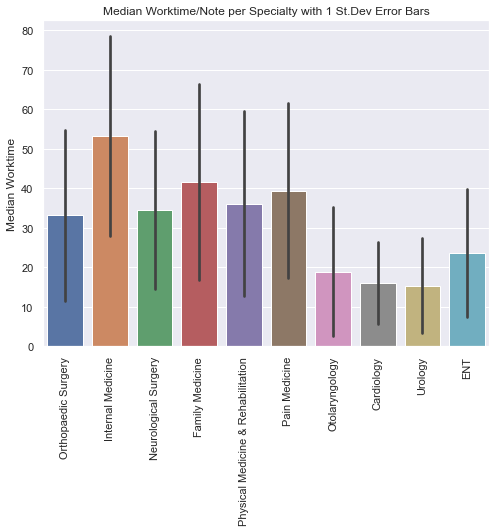

In [127]:
df_clean.groupby('specialty_name', as_index=False)['worktime'].median()

sns.set(rc={'figure.figsize':(8,6)})
plt.xticks(rotation=90)
specialty_plot = sns.barplot('specialty_name', 'worktime', data=df_clean, ci="sd")
specialty_plot.set(xlabel = None, ylabel = "Median Worktime", 
                   title = 'Median Worktime/Note per Specialty with 1 St.Dev Error Bars')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Median Worktime'),
 Text(0.5, 1.0, 'Median Worktime/Note per Patient Type with 1 St.Dev Error Bars')]

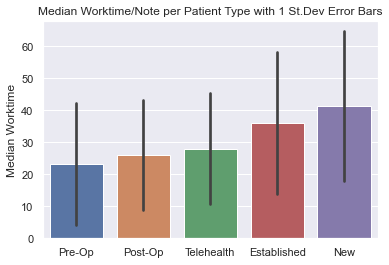

In [128]:
df_clean.groupby('pt_stage', as_index=False)['worktime'].median()

sns.set(rc={'figure.figsize':(6,4)})
specialty_plot = sns.barplot('pt_stage', 'worktime', data=df_clean, ci="sd", order=['Pre-Op', 'Post-Op', 'Telehealth', 'Established', 'New'])
specialty_plot.set(xlabel = None, ylabel = "Median Worktime", title = 'Median Worktime/Note per Patient Type with 1 St.Dev Error Bars')

In [129]:
#df_clean.groupby('group_name', as_index=False)['worktime'].median()

#sns.set(rc={'figure.figsize':(20,8.27)})
#plt.xticks(rotation=90)
#specialty_plot = sns.barplot('group_name', 'worktime', data=df_clean, ci="sd")
#specialty_plot.set(xlabel = None, ylabel = "Median Worktime", title = 'Median Worktime/Note per Group with 1 St. Dev Error Bars')

[Text(0.5, 0, ''),
 Text(0, 0.5, 'Median Worktime'),
 Text(0.5, 1.0, 'Median Worktime/Note with 1 St. Dev Error Bars')]

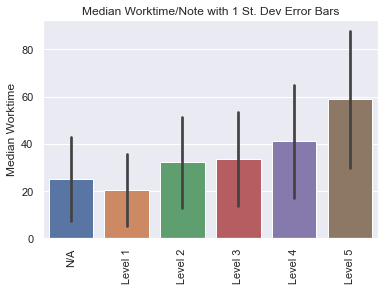

In [130]:
df_clean.groupby('em_level', as_index=False)['worktime'].median()

sns.set(rc={'figure.figsize':(6,4)})
plt.xticks(rotation=90)
specialty_plot = sns.barplot('em_level', 'worktime', data=df_clean, ci="sd", order=['N/A', 'Level 1', 'Level 2', 'Level 3', 'Level 4', 'Level 5'])
specialty_plot.set(xlabel = None, ylabel = "Median Worktime", title = 'Median Worktime/Note with 1 St. Dev Error Bars')

In [131]:
null_columns=df_clean.columns[df_clean.isnull().any()]
df_clean[null_columns].isnull().sum()

Series([], dtype: float64)

In [132]:
df_clean_7 = df_clean[['experience_sqrt',
                      'pt_stage_int', 'em_level_int', 
                      'worktime']]

In [133]:
#apply One-Hot encoding
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
df_encoded = encoder.fit_transform(df_clean_7)
df_encoded.head()

,experience_sqrt,pt_stage_int,em_level_int,worktime
0,7.000000,2,0,66
1,35.930488,4,4,73
2,17.233688,4,4,45
3,17.233688,4,4,32
4,15.779734,4,3,52


In [134]:
#create input and output arrays
x, y = df_encoded.iloc[:, :-1], df_encoded.iloc[:,-1]
#x, y

### Linear Model:

#### Linear model with experience (sqrt(days scribing + note count)) encoded E&M stage, and encoded patient stage to predict work time, R-squared = 0.704

In [135]:
import statsmodels.regression.linear_model as sm

ols = sm.OLS(endog = y, exog = x).fit()
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:               worktime   R-squared (uncentered):                   0.704
Model:                            OLS   Adj. R-squared (uncentered):              0.704
Method:                 Least Squares   F-statistic:                          2.092e+05
Date:                Sat, 28 Aug 2021   Prob (F-statistic):                        0.00
Time:                        20:44:50   Log-Likelihood:                     -1.1905e+06
No. Observations:              263817   AIC:                                  2.381e+06
Df Residuals:                  263814   BIC:                                  2.381e+06
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
experience_sqrt    -0.1748      0.002    -71.192      0.000      -0.180      -0.170
pt_stage_int       11.5094      0.045    256.835      0.000      11.422      11.597
em_level_int       -1.6880      0.047    -36.047      0.000      -1.780      -1.596
==============================================================================
Omnibus:                   113596.566   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           799108.700
Skew:                           1.934   Prob(JB):                         0.00
Kurtosis:                      10.598   Cond. No.                         48.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""